# Explore loading, reformatting and reprojecting NSIDC-0081 

In [31]:
from pathlib import Path

import numpy as np

import rioxarray
import xarray as xr

from affine import Affine

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

EXAMPLE_DATA = Path('../example_data/NSIDC0081_SEAICE_PS_N25km_20230627_v2.0.nc')

In [15]:
ds = xr.open_dataset(EXAMPLE_DATA, decode_coords='all', mask_and_scale=False)
ds

<xarray.Dataset>
Dimensions:     (x: 304, y: 448, time: 1)
Coordinates:
    crs         |S1 ...
  * x           (x) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y           (y) float64 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * time        (time) datetime64[ns] 2023-06-27
Data variables:
    F16_ICECON  (time, y, x) uint8 ...
    F17_ICECON  (time, y, x) uint8 ...
    F18_ICECON  (time, y, x) uint8 ...
Attributes: (12/49)
    title:                     Near-Real-Time DMSP SSMIS Daily Polar Gridded ...
    summary:                   This data set provides a Near-Real-Time (NRT) ...
    id:                        10.5067/YTTHO2FJQ97K
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    metadata_link:             https://doi.org/10.5067/YTTHO2FJQ97K
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    NOAA Comprehensive Large Array-data Stewardshi...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounde...
    platform:                  DMSP 5D-3/F16 > Defense Meteorological Satelli...

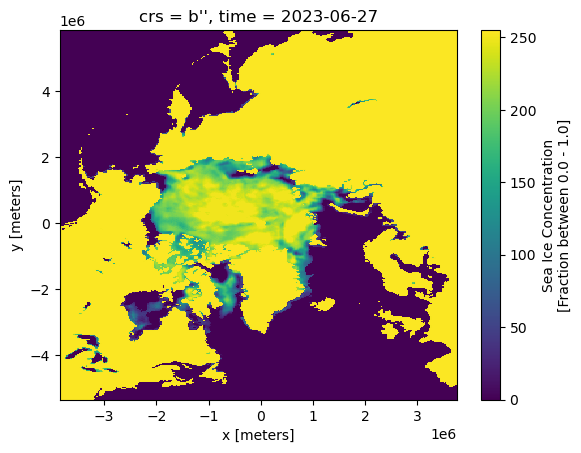

In [16]:
ds.F16_ICECON[0,:,:].plot()

## Reproject Data

Define projection and grid parameters

In [17]:
destination_crs = 'EPSG:6931'
ncols = 720
nrows = 720
cell_width = 25000.0
cell_height = -25000.0
grid_upper_left_x = -9000000.0
grid_upper_left_y = 9000000.0

Define transform as affine matrix

In [18]:
gt = (cell_width, 0.0, grid_upper_left_x, 0.0, cell_height, grid_upper_left_y)
transform = Affine(*gt)

Reproject data

In [19]:
ds_ease2 = ds.rio.reproject(destination_crs, shape=(nrows, ncols), transform=transform)

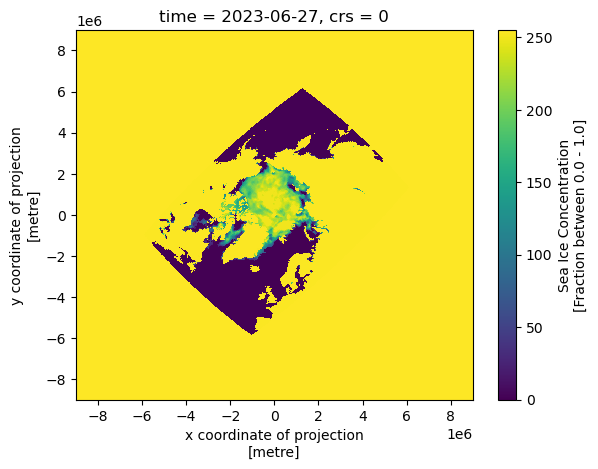

In [20]:
ds_ease2.F16_ICECON[0,:,:].plot()

## Mask and Scale Data

In [21]:
src_crs = ds.rio.crs
for var in ds.data_vars:
    ds[var] = ds[var].where(ds[var] <= 250)
ds = xr.decode_cf(ds)
ds.rio.write_crs(src_crs, inplace=True)

<xarray.Dataset>
Dimensions:      (x: 304, y: 448, time: 1)
Coordinates:
    crs          |S1 ...
  * x            (x) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y            (y) float64 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * time         (time) datetime64[ns] 2023-06-27
    spatial_ref  int64 0
Data variables:
    F16_ICECON   (time, y, x) float64 ...
    F17_ICECON   (time, y, x) float64 ...
    F18_ICECON   (time, y, x) float64 ...
Attributes: (12/49)
    title:                     Near-Real-Time DMSP SSMIS Daily Polar Gridded ...
    summary:                   This data set provides a Near-Real-Time (NRT) ...
    id:                        10.5067/YTTHO2FJQ97K
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    metadata_link:             https://doi.org/10.5067/YTTHO2FJQ97K
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    NOAA Comprehensive Large Array-data Stewardshi...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounde...
    platform:                  DMSP 5D-3/F16 > Defense Meteorological Satelli...

In [24]:
dst_crs = ds_ease2.rio.crs
for var in ds_ease2.data_vars:
    ds_ease2[var] = ds_ease2[var].where(ds_ease2[var] <= 250)
ds_ease2 = xr.decode_cf(ds_ease2)
ds_ease2.rio.write_crs(dst_crs, inplace=True)

<xarray.Dataset>
Dimensions:      (x: 720, y: 720, time: 1)
Coordinates:
  * x            (x) float64 -8.988e+06 -8.962e+06 ... 8.962e+06 8.988e+06
  * y            (y) float64 8.988e+06 8.962e+06 ... -8.962e+06 -8.988e+06
  * time         (time) datetime64[ns] 2023-06-27
    crs          int64 ...
    spatial_ref  int64 0
Data variables:
    F16_ICECON   (time, y, x) float64 ...
    F17_ICECON   (time, y, x) float64 ...
    F18_ICECON   (time, y, x) float64 ...
Attributes: (12/49)
    title:                     Near-Real-Time DMSP SSMIS Daily Polar Gridded ...
    summary:                   This data set provides a Near-Real-Time (NRT) ...
    id:                        10.5067/YTTHO2FJQ97K
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    metadata_link:             https://doi.org/10.5067/YTTHO2FJQ97K
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    NOAA Comprehensive Large Array-data Stewardshi...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounde...
    platform:                  DMSP 5D-3/F16 > Defense Meteorological Satelli...

## Plot Original and Reprojected Data

In [26]:
hughes1980_globe = ccrs.Globe(semimajor_axis=6378273, inverse_flattening=298.279411123061)
psnorth_ccrs = ccrs.Stereographic(central_latitude=90., central_longitude=-45., true_scale_latitude=70.,
                                  globe=hughes1980_globe)
ease2_ccrs = ccrs.LambertAzimuthalEqualArea(central_longitude=0., central_latitude=90.)

Text(0.5, 1.0, 'Reprojected EASE v2.0')

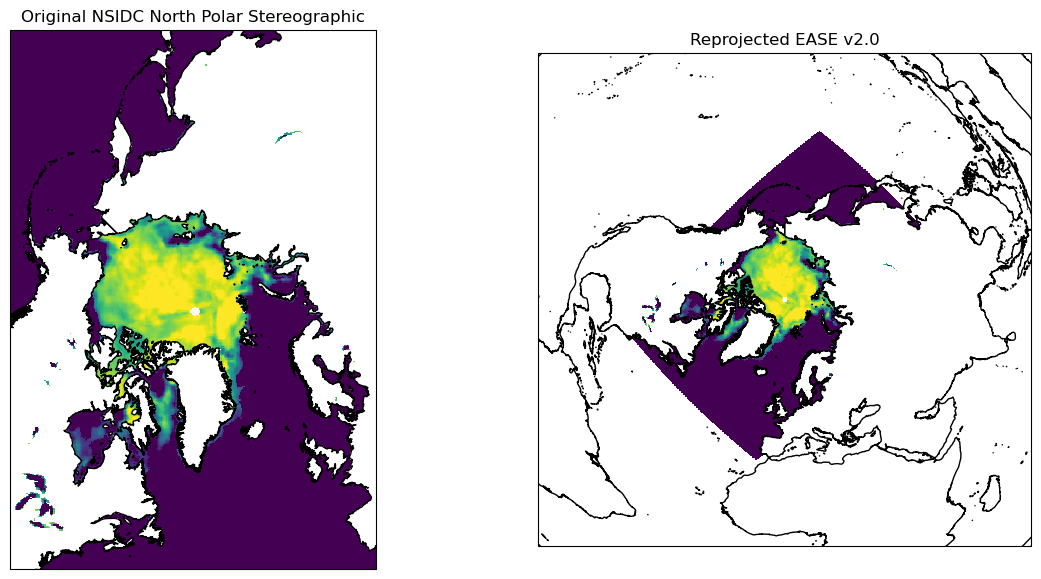

In [28]:
coastline = cfeature.GSHHSFeature(scale='low', levels=[1], edgecolor='black', facecolor='none')

fig = plt.figure(figsize=(14,7))

# Original Data
ax1 = fig.add_subplot(1, 2, 1, projection=psnorth_ccrs)
ax1.set_extent([ds.rio.bounds()[i] for i in [0,2,1,3]], psnorth_ccrs)   # rioxarray bounds are left, bottom, right, top
                                                                     # cartopy expects xmin, xmax, ymin, ymax
ax1.add_feature(coastline)
ds.F16_ICECON[0,:,:].where(ds.F16_ICECON[0,:,:] <= 250).plot(ax=ax1, add_colorbar=False)
ax1.set_title("Original NSIDC North Polar Stereographic")

# Reprojected data in EASE2 
ax2 = fig.add_subplot(1, 2, 2, projection=ease2_ccrs)
ax2.set_extent([ds_ease2.rio.bounds()[i] for i in [0,2,1,3]], ease2_ccrs)  # rioxarray bounds are left, bottom, right, top
                                                                     # cartopy expects xmin, xmax, ymin, ymax
ax2.add_feature(coastline)
ds_ease2.F16_ICECON[0,:,:].plot(ax=ax2, add_colorbar=False)
ax2.set_title("Reprojected EASE v2.0");

## Plot sub-regions of original and reprojected data to compare land masks

In [69]:
def make_comparison_plot(lon_ctr, lat_ctr, da_src, da_dst, src_crs, dst_crs, buffer=100000.,):
    """Make a two panel plot showing data on source and destination grids
    
    :lon_ctr: longitude of map center
    :lat_ctr: latitude of map center
    :da_src: source dataarray
    :da_dst: destination dataarray
    :src_crs: source crs
    :dst_crs: destination crs
    """
    coastline = cfeature.GSHHSFeature(scale='high', levels=[1], edgecolor='black', facecolor='none')

    src_center = src_crs.transform_point(lon_ctr, lat_ctr, ccrs.PlateCarree())
    src_map_extent = np.concatenate([a + np.array([-1*buffer, buffer]) for a in src_center])
    
    dst_center = dst_crs.transform_point(lon_ctr, lat_ctr, ccrs.PlateCarree()) 
    dst_map_extent = np.concatenate([a + np.array([-1*buffer, buffer]) for a in dst_center])
    
    fig = plt.figure(figsize=(14,7))
    
    # Plot original field
    ax1 = fig.add_subplot(1, 2, 1, projection=src_crs)
    ax1.set_extent(src_map_extent, src_crs)
    ax1.add_feature(coastline)
    img1 = da_src.plot(ax=ax1, vmin=0., vmax=1., add_colorbar=False)
    # Overlay center-points for grid cells
    src_x2d, src_y2d = np.meshgrid(da_src.x, da_src.y)
    ax1.scatter(src_x2d, src_y2d, marker='x', c='0.5')
    # Plot location of center
    ax1.scatter(src_center[0], src_center[1], marker='x', c='cyan')
    ax1.set_title("Original NSIDC North Polar Stereographic")
    
    # Plot reprojected
    ax2 = fig.add_subplot(1, 2, 2, projection=dst_crs)
    ax2.set_extent(dst_map_extent, dst_crs)
    ax2.add_feature(coastline)
    img = da_dst.plot(ax=ax2, add_colorbar=False, vmin=0., vmax=1.)
    # Overlay center-points for grid cells
    dst_x2d, dst_y2d = np.meshgrid(da_dst.x, da_dst.y)
    ax2.scatter(dst_x2d, dst_y2d, marker='.', c='0.5')
    # Add source cells to indicate valid and non-valid grid cells
    src_colors = np.where(da_src.notnull(), 'red', '0.75').flatten() 
    ax2.scatter(src_x2d, src_y2d, marker='x', c=src_colors, transform=src_crs)
    # Plot location of center
    ax2.scatter(src_center[0], src_center[1], marker='x', c='cyan')
    ax2.set_title("Reprojected EASE v2.0")

    #fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.95, wspace=0.01, hspace=0.01)
    #cax = fig.add_axes([0.2, 0.02, 0.8, 0.05])
    #fig.colorbar(img, label='Sea Ice Concentration', ax=[ax1,ax2], location='bottom', shrink=0.75)
    #fig.tight_layout()
    return

### Plot Around Svalbard

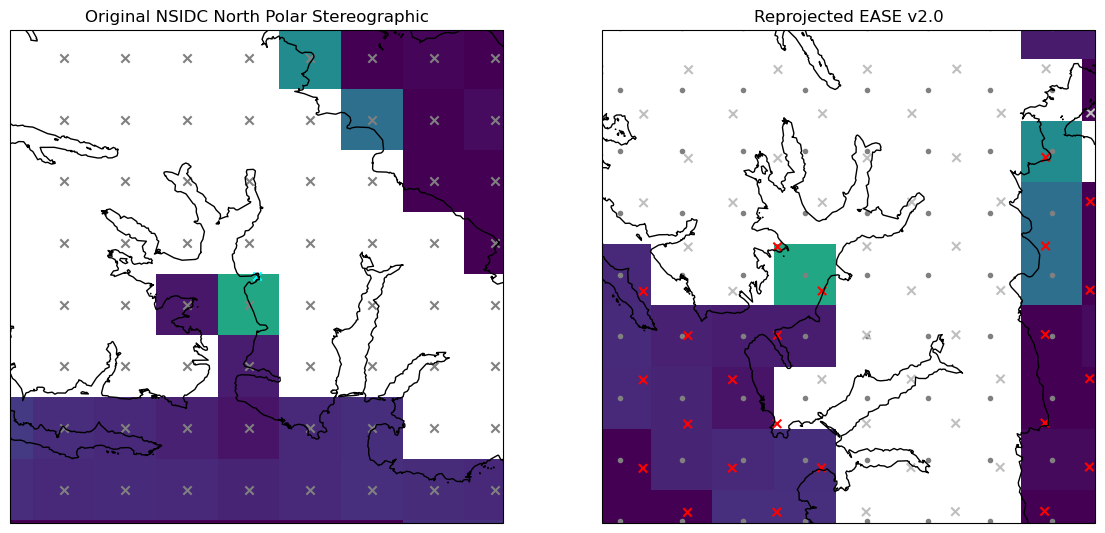

In [70]:
buffer = 100000.
longitude = 15.702697636401592
latitude = 78.22962755545672

make_comparison_plot(longitude, latitude, 
                     ds.F16_ICECON[0,:,:], ds_ease2.F16_ICECON[0,:,:],
                     psnorth_ccrs, ease2_ccrs,
                     buffer=buffer)

## Region Plot of NE Greenland

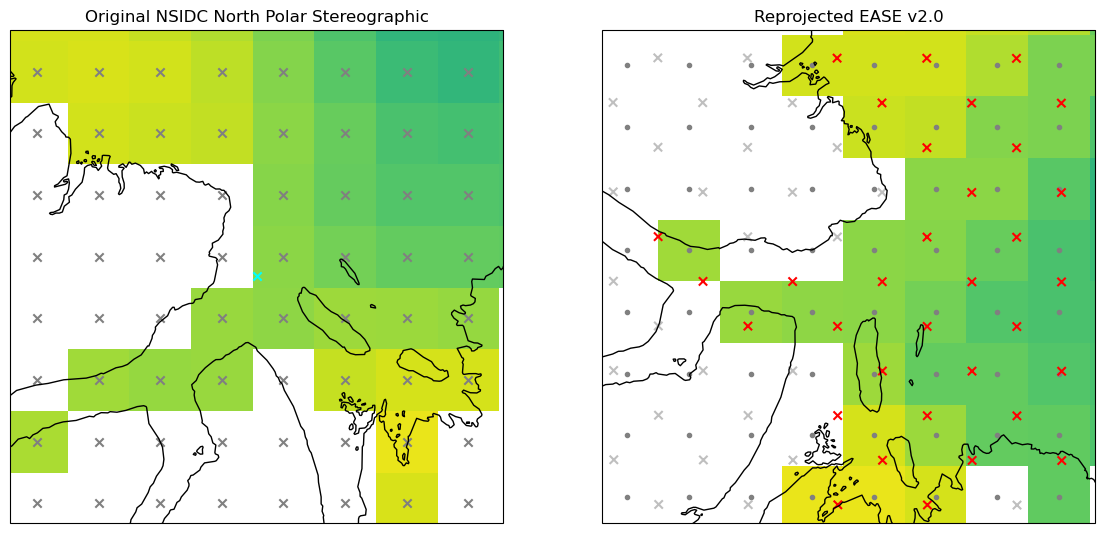

In [71]:
buffer = 100000.
longitude = -22.028156071045196
latitude = 82.28626999533523

make_comparison_plot(longitude, latitude, 
                     ds.F16_ICECON[0,:,:], ds_ease2.F16_ICECON[0,:,:],
                     psnorth_ccrs, ease2_ccrs,
                     buffer=buffer)

## Plot Coast at Prudhoe Bay 

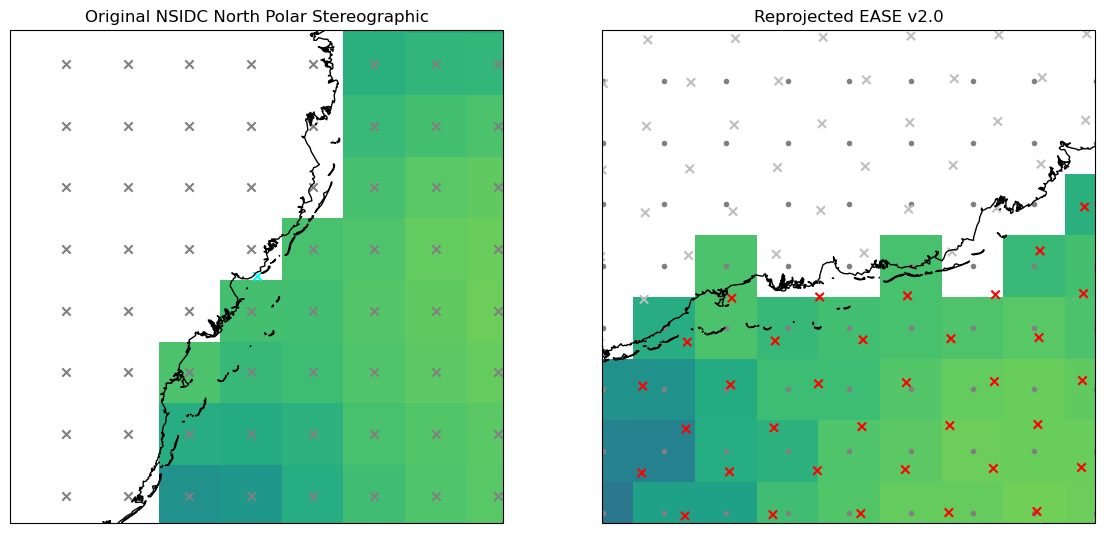

In [72]:
longitude = -148.52113814795558
latitude = 70.38841462633614

make_comparison_plot(longitude, latitude, 
                     ds.F16_ICECON[0,:,:], ds_ease2.F16_ICECON[0,:,:],
                     psnorth_ccrs, ease2_ccrs,
                     buffer=buffer)

## Extract mask

The grids are masked with three masks: a pole-hole mask, a coastal mask, and a land mask.  A separate coast mask is used in addition to a land mask because mixed land and ocean cells contaminate the passive microwave signal. A separate "valid-ice" mask that is based on sea surface temperature and sea ice climatology is also used to filter out spurious sea ice signals.  [**check this**]  Cells that are not pole-hole, coast or land but are not valid ice have zero sea ice concentration.

Mask values are embedded in the grids.  This is not optimal for scaling data or for calculations.  It is better to set non-valid data (i.e. pole-hole, land and coast cells, as well as missing cells) to NaN and provide separate masks for the pole hole, coast and land cells.

The table below shows the counts of cells in the different mask, along with counts of valid cells and missing cells.

In [46]:
def count_mask(da, maskvalue):
    return (da == maskvalue).sum().values

def count_valid(da):
    return (da <= 250).sum().values

print("Variable       Valid     Pole   Unused    Coast     Land  Missing")
for var in ds.data_vars:
    s = f"{var}: {count_valid(ds[var]):8d} "
    for maskval in [251, 252, 253, 254, 255]:
        s += f"{count_mask(ds[var], maskval):8d} "
    print(s)


Variable       Valid     Pole   Unused    Coast     Land  Missing
F16_ICECON:    67879       44        0     5052    63212        5 
F17_ICECON:    67883       44        0     5052    63212        1 
F18_ICECON:    67882       44        0     5052    63212        2 


In [119]:
crs = ds.rio.crs  # Save because xarray operations set this to None

pole_hole = (ds.F16_ICECON == 251).squeeze().astype('int')
coast = (ds.F16_ICECON == 253).squeeze().astype('int')
land = (ds.F16_ICECON == 254).squeeze().astype('int')
for var in ds.data_vars:
    ds[var] = ds[var].where(ds[var] <= 250)
    
pole_hole.attrs = {
    'units': 'none',
    'long_name': 'arctic_pole_hole_mask',
    'valid_range': [0, 1]
}

coast.attrs = {
    'units': 'none',
    'long_name': 'coast_mask',
    'valid_range': [0, 1]
}
    
land.attrs = {
    'units': 'none',
    'long_name': 'land_mask',
    'valid_range': [0, 1]
}
    
ds['pole_hole_mask'] = pole_hole
ds['coast_mask'] = coast
ds['land_mask'] = land

# Scale and mask data variables
ds = xr.decode_cf(ds)

# A CRS is set for the Dataset but not for individual data arrays
ds.rio.write_crs(crs, inplace=True)

<xarray.Dataset>
Dimensions:         (x: 304, y: 448, time: 1)
Coordinates:
    crs             |S1 ...
  * x               (x) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y               (y) float64 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * time            (time) datetime64[ns] 2023-06-27
    spatial_ref     int64 0
Data variables:
    F16_ICECON      (time, y, x) float64 ...
    F17_ICECON      (time, y, x) float64 ...
    F18_ICECON      (time, y, x) float64 ...
    pole_hole_mask  (y, x) int64 ...
    coast_mask      (y, x) int64 ...
    land_mask       (y, x) int64 ...
Attributes: (12/49)
    title:                     Near-Real-Time DMSP SSMIS Daily Polar Gridded ...
    summary:                   This data set provides a Near-Real-Time (NRT) ...
    id:                        10.5067/YTTHO2FJQ97K
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    metadata_link:             https://doi.org/10.5067/YTTHO2FJQ97K
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    NOAA Comprehensive Large Array-data Stewardshi...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounde...
    platform:                  DMSP 5D-3/F16 > Defense Meteorological Satelli...